In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-04-01 06:24:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-04-01 06:24:07 (139 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



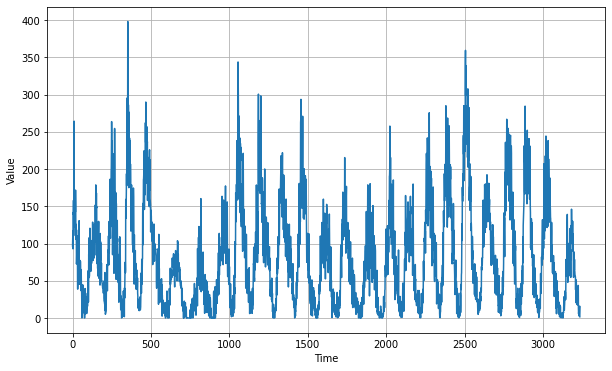

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


Find optimal learning rate

In [9]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

model = tf.keras.models.Sequential([
  Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",
         activation="relu", input_shape=[None, 1]),
  LSTM(64, return_sequences=True),
  LSTM(64, return_sequences=True),
  Dense(30, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1),
  Lambda(lambda x: x * 400)
])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)

model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 0s 28ms/step - loss: 80.0357 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 78.3454 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 23ms/step - loss: 75.4876 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 23ms/step - loss: 72.5510 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 24ms/step - loss: 69.0571 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 26ms/step - loss: 65.5337 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 61.4206 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 25ms/step - loss: 58.5597 - mae: 58.6369 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 0s 24ms/step - loss: 55.3287 - mae:

Plot learning rate against loss

(1e-08, 0.0001, 0.0, 60.0)

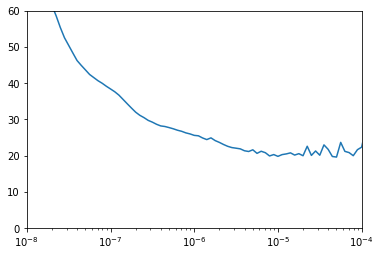

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Window size 64 -> 60 ----- Batch size 256 -> 100

Conv1D 32 -> 60 ----- LSTM 64 -> 60

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  Conv1D(filters=60, kernel_size=5, strides=1, padding="causal",
         activation="relu", input_shape=[None, 1]),
  LSTM(60, return_sequences=True),
  LSTM(60, return_sequences=True),
  Dense(30, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1),
  Lambda(lambda x: x * 400)
])


optimizer = SGD(lr=1e-5, momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 15ms/step - loss: 38.7166 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 25.7312 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 14ms/step - loss: 22.0651 - mae: 22.5702
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 20.4689 - mae: 20.9657
Epoch 5/500
30/30 [==============================] - 0s 13ms/step - loss: 19.7126 - mae: 20.2069
Epoch 6/500
30/30 [==============================] - 0s 13ms/step - loss: 19.2562 - mae: 19.7662
Epoch 7/500
30/30 [==============================] - 0s 13ms/step - loss: 18.5751 - mae: 19.0879
Epoch 8/500
30/30 [==============================] - 0s 13ms/step - loss: 18.2467 - mae: 18.7158
Epoch 9/500
30/30 [==============================] - 0s 13ms/step - loss: 18.1639 - mae: 18.6248
Epoch 10/500
30/30 [==============================] - 0s 13ms/step - loss: 18.6561 - mae: 19.1578
Epoch 11/500
30/30 [=========

In [0]:
from tensorflow.keras.metrics import mean_absolute_error

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
mae = mean_absolute_error(x_valid, rnn_forecast).numpy()

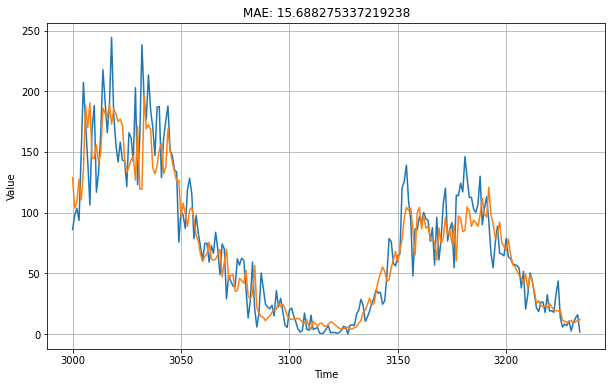

In [13]:
plt.figure(figsize=(10, 6))
plt.title(f'MAE: {mae}')
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

<Figure size 432x288 with 0 Axes>

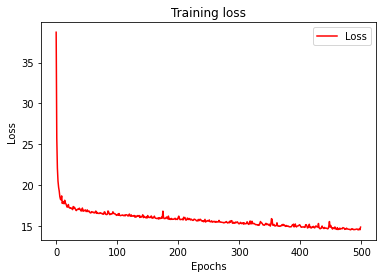

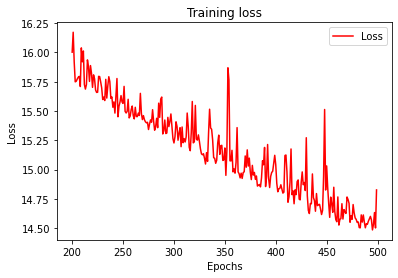

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [15]:
print(rnn_forecast)

[128.91782   103.76587   108.44109   127.48231   110.37271   135.11356
 188.41765   169.8       190.35603   144.72963   144.78278   155.68346
 141.31682   149.5879    186.21266   181.69177   178.47414   189.3353
 172.81883   185.51955   181.17294   174.98592   177.08847   172.26727
 143.75624   133.07507   137.94505   143.50557   146.6871    126.689316
 171.26201   119.45448   119.21633   196.62827   168.9172    172.42802
 168.32806   136.87329   131.9661    138.61046   151.49185   156.95662
 132.09818   137.56253   169.00626   151.3797    141.89754   133.8747
 125.94794   126.543236   96.84457   107.855034   99.008026   88.67124
 102.19294   104.121124   94.28667    81.12799    76.6427     65.91583
  59.689735   63.833572   66.12615    75.69826    61.65155    60.73098
  61.743908   65.3745     69.578026   46.95808    59.253605   69.702736
  45.3203     48.16924    48.93878    35.321026   35.559      45.943165
  43.816444   42.08767    52.496708   30.948088   29.050695   33.19712
  56.